In [1]:
import mne
import pandas as pd
import numpy as np

# Read data from "derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr"
data_raw=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr')


Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr...
Setting channel info structure...


In [6]:
data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr',preload=True)

Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr...
Setting channel info structure...
Reading 0 ... 67387  =      0.000 ...   336.935 secs...


C:\Users\Alex\AppData\Local\Temp\ipykernel_17520\2777862424.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr',preload=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_17520\2777862424.py:1: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr',preload=True)


In [48]:
%matplotlib tk

NameError: name 'matplotlib' is not defined

In [6]:
data_raw.plot()

Opening raw-browser...


In [44]:
data.plot()

In [11]:
data_filt=data.copy().load_data().filter(0.1,30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 sec)



In [32]:

data_filt.plot()

In [40]:

for i in [20,22,24,26,34,40,42,48]:
    print(data.ch_names[i])
#names of the reference channels of the EEG used by the authors

FC1
CP1
FC5
CP5
C1
FC3
CP3
C5


In [4]:
# Another way to extract the events, not used

#events=pd.read_table('C:/Users/ernes/Desktop/Master/Course 21-22/2nd term 21-22/Neuroimage/Week 6/task-motorloc_events.tsv')
#dummies=pd.get_dummies(events,columns=['trial_type']).drop(columns=['duration','trial_type_Rest'])
#dummies['onset']=dummies['onset']*200
#events=dummies.to_numpy()

In [12]:
events=mne.events_from_annotations(data_filt) #extract the events from the data
events 

Used Annotations descriptions: ['New Segment/', 'Pulse Artifact/R', 'Response/R128', 'Stimulus/S  1', 'Stimulus/S 99', 'TPULSE/TEND', 'TPULSE/TPEAK', 'TPULSE/TSTART']


(array([[    0,     0, 99999],
        [ 2230,     0,  1128],
        [ 2249,     0, 10001],
        ...,
        [67030,     0,  1128],
        [67075,     0, 10001],
        [67227,     0, 10001]]),
 {'New Segment/': 99999,
  'Pulse Artifact/R': 10001,
  'Response/R128': 1128,
  'Stimulus/S  1': 1,
  'Stimulus/S 99': 99,
  'TPULSE/TEND': 10002,
  'TPULSE/TPEAK': 10003,
  'TPULSE/TSTART': 10004})

In [11]:
# #select events in the task blocks
# blockstart=False
# new_events=np.zeros([1,3],dtype=np.int16)
# for i in range(len(events[0])):
#     if events[0][i,2] == 1:
#         blockstart=True
#         j=1
#     while blockstart and i+j<558:
#         if events[0][i+j,2]==10001:
#             curr_event=events[0][i+j]
#             new_events=np.concatenate((new_events,np.expand_dims(curr_event,axis=0)),axis=0)
            
#         if events[0][i+j,2]==99:
#             blockstart=False
#         j=j+1
# new_events=new_events[1:]

In [13]:
#Create a new channel called stimulation (STI) needed to add the events
stim=mne.create_info(['STI'],200,['stim'])
stim_raw=mne.io.RawArray(np.zeros([1,67388]),stim)
data_filt.load_data().add_channels([stim_raw],force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=67388
    Range : 0 ... 67387 =      0.000 ...   336.935 secs
Ready.


<RawBrainVision | sub-xp101_task-motorloc_eeg_pp.dat, 65 x 67388 (336.9 s), ~33.5 MB, data loaded>

In [ ]:
data_filt.ch_names #see the STI channel at the end

In [14]:
data_filt.add_events(events[0],stim_channel='STI',replace=True) #add the events to the data

In [15]:
event_id = {'task':1,'rest':99} #take the value of the 'Stimulus/S 10001': 10001
tmin = 2  # start of each epoch (200ms before the trigger)
tmax = 18  # end of each epoch (500ms after the trigger) 
baseline = (2, 3) 

In [16]:
reject_criteria = dict(eeg=600e-5)      
picks = mne.pick_types(data_filt.info, meg=False, eeg=True, stim=False, misc=True,
                       include=[])

In [17]:
epochs = mne.Epochs(data_filt, events[0], event_id, tmin, tmax, picks=picks, proj=False,
                    baseline=baseline, reject=reject_criteria)

Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)


In [33]:
epochs2= mne.make_fixed_length_epochs(data_filt.copy().crop(tmin=32, tmax=51))

In [45]:
epochs2.load_data().set_eeg_reference(ref_channels= ["FC1","CP1","FC5","CP5","C1","FC3","CP3","C5"]).plot()

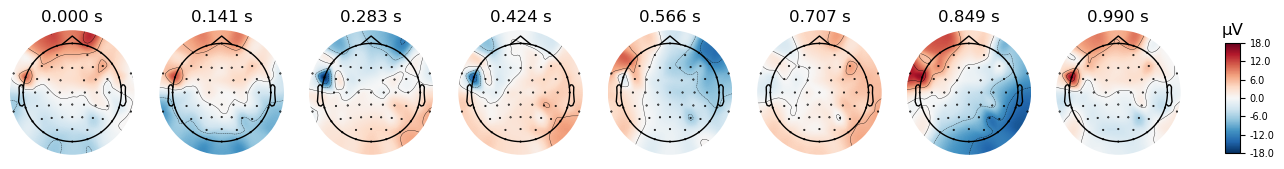

In [47]:
evoked2 = epochs2.set_eeg_reference(ref_channels= ["FC1","CP1","FC5","CP5","C1","FC3","CP3","C5"]).average() #mean of the epochs to get the evoked response
evoked2.plot(time_unit='s', gfp=True) #plot of the evoked response
evoked2.plot_topomap(times=np.linspace(0,0.99,8), ch_type='eeg',time_unit='s')

In [35]:
#matplotlib tk
czepochs=epochs.copy().load_data().pick_channels(['Cz'])
czepochs.plot()

In [20]:
epochs.load_data().set_eeg_reference().plot()

In [25]:
print(epochs['task'])

<Epochs |  8 events (all good), 2 - 18 sec, baseline 2 – 18 sec, ~92 kB, data not loaded,
 'task': 8>


In [39]:
epochs.plot_image(picks=['Pz'])

[<Figure size 640x480 with 4 Axes>]

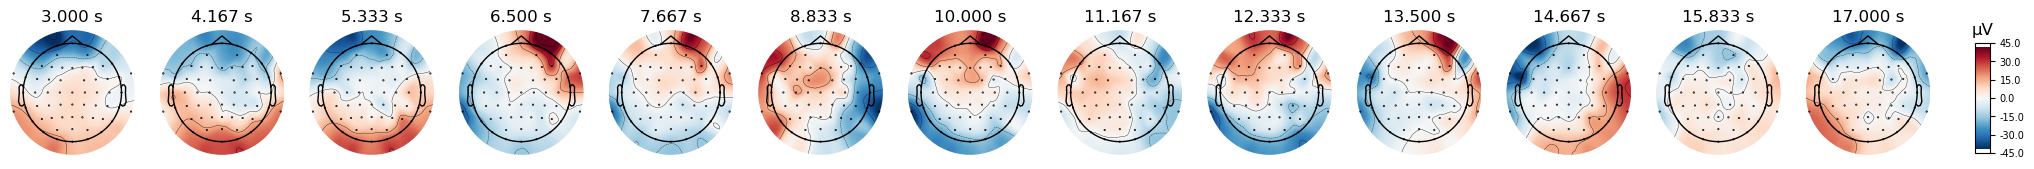

In [21]:
evoked = epochs['task'].set_eeg_reference().average() #mean of the epochs to get the evoked response
evoked.plot(time_unit='s', gfp=True) #plot of the evoked response
evoked.plot_topomap(times=np.linspace(3, 17, 13), ch_type='eeg',time_unit='s') #topomap

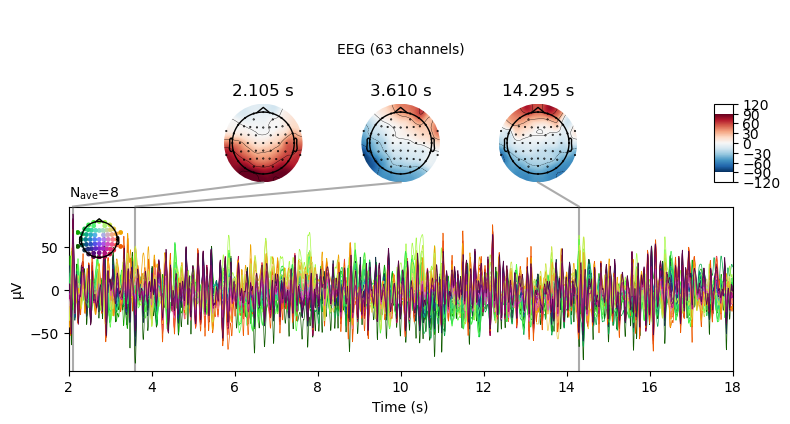

In [13]:
mne.viz.plot_evoked_joint(evoked)

# Time to make BEM and Source images!

In [14]:
noise_cov = mne.compute_covariance(
    epochs, method=['shrunk', 'empirical'], rank=None, verbose=True)

Using data from preloaded Raw for 8 events and 3201 original time points ...
Using data from preloaded Raw for 7 events and 3201 original time points ...
Computing rank from data with rank=None
    Using tolerance 5.9e-10 (2.2e-16 eps * 63 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 48015
log-likelihood on unseen data (descending order):
   shrunk: -245.945
   empirical: -267.525
selecting best estimator: shrunk
[done]


In [15]:
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, data_filt.info)

C:\Users\Alex\AppData\Local\Temp\ipykernel_15676\355871161.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked.plot_white(noise_cov, time_unit='s')


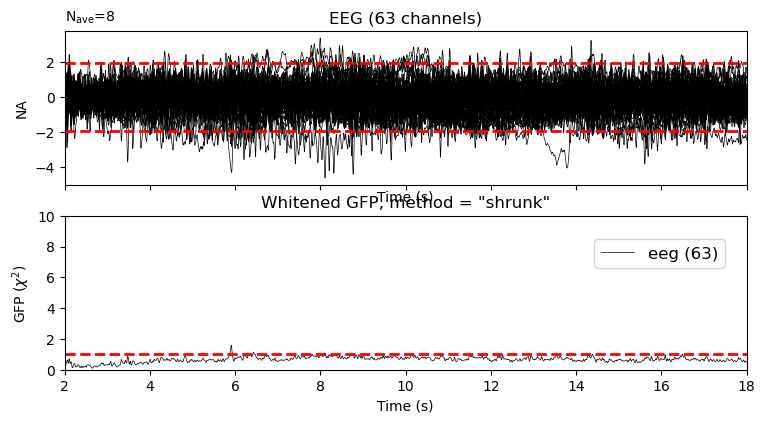

In [16]:
evoked.plot_white(noise_cov, time_unit='s')

In [39]:
mne.gui.coregistration()

KeyError: 'Key "SUBJECTS_DIR" not found in the environment or in the the mne-python config file (C:\\Users\\Alex\\.mne\\mne-python.json). Try either os.environ["SUBJECTS_DIR"] = VALUE for a temporary solution, or mne.utils.set_config("SUBJECTS_DIR", VALUE, set_env=True) for a permanent one. You can also set the environment variable before running python.'